In [3]:
import pandas as pd
data = pd.read_csv('inverter Data Set.csv')


In [4]:
dfx1 = data.iloc[:,0:-3]
#dfy1 = data_raw[['u_a_k-1','u_b_k-1','u_c_k-1']]
dfy1 = data.iloc[:,-3:-2]


In [5]:
from sklearn.model_selection import train_test_split    
X_train, X_test1, y_train, y_test = train_test_split(dfx1, dfy1, test_size=0.30, shuffle=False)


In [4]:
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

# PSO Parameters
class Particle:
    def __init__(self, dim, bounds):
        self.position = np.array([random.uniform(bounds[d][0], bounds[d][1]) for d in range(dim)])
        self.velocity = np.zeros(dim)
        self.best_position = np.copy(self.position)
        self.best_score = float('inf')

def pso_optimize(func, dim, bounds, n_particles=10, max_iter=30, w=0.5, c1=1.5, c2=1.5, early_stop=5):
    particles = [Particle(dim, bounds) for _ in range(n_particles)]
    global_best = min(particles, key=lambda p: func(p.position))
    
    best_loss = func(global_best.position)
    no_improve_count = 0
    
    for _ in range(max_iter):
        for particle in particles:
            score = func(particle.position)
            if score < particle.best_score:
                particle.best_score = score
                particle.best_position = np.copy(particle.position)
            
            if score < best_loss:
                global_best = particle
                best_loss = score
                no_improve_count = 0
            else:
                no_improve_count += 1
            
            # Early stopping
            if no_improve_count >= early_stop:
                return global_best.position, best_loss
            
            # Update velocity and position
            inertia = w * particle.velocity
            cognitive = c1 * random.random() * (particle.best_position - particle.position)
            social = c2 * random.random() * (global_best.position - particle.position)
            particle.velocity = inertia + cognitive + social
            particle.position += particle.velocity
            
    return global_best.position, best_loss

# PSO for Regression Models
def regression_pso(model_class, param_bounds, n_particles=5, max_iter=15):
    y =np.array(Y_test).ravel()
    X_train, X_test, y_train, y_test = train_test_split(X_test1, y, test_size=0.2, random_state=42)
    
    def model_fitness(params):
        params = {key: int(val) if isinstance(param_bounds[key][0], int) else val for key, val in zip(param_bounds.keys(), params)}
        model = model_class(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return mean_squared_error(y_test, y_pred)
    
    bounds = list(param_bounds.values())
    best_params, best_loss = pso_optimize(model_fitness, len(bounds), bounds, n_particles, max_iter)
    
    best_params_dict = {key: int(val) if isinstance(param_bounds[key][0], int) else val for i, (key, val) in enumerate(zip(param_bounds.keys(), best_params))}
    return best_params_dict, best_loss

if __name__ == "__main__":
    models = {
        # "DecisionTree": (DecisionTreeRegressor, {"max_depth": (1, 10), "min_samples_split": (2, 10)}),
        "GradientBoosting": (GradientBoostingRegressor, {"n_estimators": (50, 100), "learning_rate": (0.05, 0.2)}),
        "XGBRegressor": (XGBRegressor, {"n_estimators": (50, 100), "learning_rate": (0.05, 0.2)}),
        "RandomForest": (RandomForestRegressor, {"n_estimators": (50, 100), "max_depth": (1, 10)})
    }
    
    for name, (model_class, param_bounds) in models.items():
        print(f"Optimizing {name} using PSO...")
        best_params, best_loss = regression_pso(model_class, param_bounds)
        print(f"Best Parameters: {best_params}, Best Loss: {best_loss}\n")

Optimizing GradientBoosting using PSO...


KeyboardInterrupt: 

In [ ]:
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from joblib import Parallel, delayed  # For parallel processing

# Particle class for PSO
class Particle:
    def __init__(self, dim, bounds):
        self.position = np.array([random.uniform(bounds[d][0], bounds[d][1]) for d in range(dim)])
        self.velocity = np.zeros(dim)
        self.best_position = np.copy(self.position)
        self.best_score = float('inf')

def pso_optimize(func, dim, bounds, n_particles=7, max_iter=20, w=0.5, c1=1.5, c2=1.5, early_stop=5):
    particles = [Particle(dim, bounds) for _ in range(n_particles)]
    global_best = min(particles, key=lambda p: func(p.position))

    best_loss = func(global_best.position)
    no_improve_count = 0

    for _ in range(max_iter):
        # Parallel evaluation of particle fitness
        scores = Parallel(n_jobs=-1)(delayed(func)(p.position) for p in particles)

        for i, particle in enumerate(particles):
            score = scores[i]

            if score < particle.best_score:
                particle.best_score = score
                particle.best_position = np.copy(particle.position)

            if score < best_loss:
                global_best = particle
                best_loss = score
                no_improve_count = 0
            else:
                no_improve_count += 1

            # Early stopping
            if no_improve_count >= early_stop:
                return global_best.position, best_loss

            # Update velocity and position
            inertia = w * particle.velocity
            cognitive = c1 * random.random() * (particle.best_position - particle.position)
            social = c2 * random.random() * (global_best.position - particle.position)
            particle.velocity = inertia + cognitive + social

            # Update position and ensure it stays within bounds
            particle.position += particle.velocity
            particle.position = np.clip(particle.position, [b[0] for b in bounds], [b[1] for b in bounds])

    return global_best.position, best_loss

# Function to optimize regression model using PSO
def regression_pso(model_class, param_bounds, X_train, X_test, y_train, y_test, n_particles=7, max_iter=12):
    def model_fitness(params):
        # Convert parameters to correct types (int for discrete values)
        params = {key: int(val) if isinstance(param_bounds[key][0], int) else val for key, val in zip(param_bounds.keys(), params)}
        model = model_class(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return mean_squared_error(y_test, y_pred)

    bounds = list(param_bounds.values())
    best_params, best_loss = pso_optimize(model_fitness, len(bounds), bounds, n_particles, max_iter)

    # Convert best parameters to correct types
    best_params_dict = {key: int(val) if isinstance(param_bounds[key][0], int) else val for key, val in zip(param_bounds.keys(), best_params)}
    return best_params_dict, best_loss

# Generate sample regression data
X, Y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

if __name__ == "__main__":
    models = {
        "GradientBoosting": (GradientBoostingRegressor, {"n_estimators": (50, 100), "learning_rate": (0.05, 0.2)}),
        "XGBRegressor": (XGBRegressor, {"n_estimators": (50, 100), "learning_rate": (0.05, 0.2)}),
        "RandomForest": (RandomForestRegressor, {"n_estimators": (50, 100), "max_depth": (1, 10)})
    }

    for name, (model_class, param_bounds) in models.items():
        print(f"Optimizing {name} using PSO...")
        best_params, best_loss = regression_pso(model_class, param_bounds, X_train, X_test, Y_train, Y_test)
        print(f"Best Parameters: {best_params}, Best Loss: {best_loss}\n")


Optimizing GradientBoosting using PSO...
Best Parameters: {'n_estimators': 95, 'learning_rate': 0.18068326107174232}, Best Loss: 966.7597823129357

Optimizing XGBRegressor using PSO...
Best Parameters: {'n_estimators': 67, 'learning_rate': 0.11974981294015839}, Best Loss: 1506.2004467484524

Optimizing RandomForest using PSO...
Best Parameters: {'n_estimators': 67, 'max_depth': 8}, Best Loss: 2754.9013856246956



In [8]:
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from joblib import Parallel, delayed  # For parallel processing

# Particle class for PSO
class Particle:
    def __init__(self, dim, bounds):
        self.position = np.array([random.uniform(bounds[d][0], bounds[d][1]) for d in range(dim)])
        self.velocity = np.zeros(dim)
        self.best_position = np.copy(self.position)
        self.best_score = float('inf')

def pso_optimize(func, dim, bounds, n_particles=7, max_iter=20, w=0.5, c1=1.5, c2=1.5, early_stop=5):
    particles = [Particle(dim, bounds) for _ in range(n_particles)]
    global_best = min(particles, key=lambda p: func(p.position))

    best_loss = func(global_best.position)
    no_improve_count = 0

    for _ in range(max_iter):
        # Parallel evaluation of particle fitness
        scores = Parallel(n_jobs=-1)(delayed(func)(p.position) for p in particles)

        for i, particle in enumerate(particles):
            score = scores[i]

            if score < particle.best_score:
                particle.best_score = score
                particle.best_position = np.copy(particle.position)

            if score < best_loss:
                global_best = particle
                best_loss = score
                no_improve_count = 0
            else:
                no_improve_count += 1

            # Early stopping
            if no_improve_count >= early_stop:
                return global_best.position, best_loss

            # Update velocity and position
            inertia = w * particle.velocity
            cognitive = c1 * random.random() * (particle.best_position - particle.position)
            social = c2 * random.random() * (global_best.position - particle.position)
            particle.velocity = inertia + cognitive + social

            # Update position and ensure it stays within bounds
            particle.position += particle.velocity
            particle.position = np.clip(particle.position, [b[0] for b in bounds], [b[1] for b in bounds])

    return global_best.position, best_loss

# Function to optimize regression model using PSO
def regression_pso(model_class, param_bounds, X_train, X_test, y_train, y_test, n_particles=7, max_iter=12):
    def model_fitness(params):
        # Convert parameters to correct types (int for discrete values)
        params = {key: int(val) if isinstance(param_bounds[key][0], int) else val for key, val in zip(param_bounds.keys(), params)}
        model = model_class(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return mean_squared_error(y_test, y_pred)

    bounds = list(param_bounds.values())
    best_params, best_loss = pso_optimize(model_fitness, len(bounds), bounds, n_particles, max_iter)

    # Convert best parameters to correct types
    best_params_dict = {key: int(val) if isinstance(param_bounds[key][0], int) else val for key, val in zip(param_bounds.keys(), best_params)}
    return best_params_dict, best_loss

# Generate sample regression data
# X, Y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)
y = np.array(y_test).ravel()
X_train, X_test, Y_train, Y_test = train_test_split(X_test1, y, test_size=0.2, random_state=42)

if __name__ == "__main__":
    models = {
        "GradientBoosting": (GradientBoostingRegressor, {"n_estimators": (50, 100), "learning_rate": (0.05, 0.2)}),
        "XGBRegressor": (XGBRegressor, {"n_estimators": (50, 100), "learning_rate": (0.05, 0.2)}),
        "RandomForest": (RandomForestRegressor, {"n_estimators": (50, 100), "max_depth": (1, 10)})
    }

    for name, (model_class, param_bounds) in models.items():
        print(f"Optimizing {name} using PSO...")
        best_params, best_loss = regression_pso(model_class, param_bounds, X_train, X_test, Y_train, Y_test)
        print(f"Best Parameters: {best_params}, Best Loss: {best_loss}\n")


Optimizing GradientBoosting using PSO...
Best Parameters: {'n_estimators': 96, 'learning_rate': 0.19104527704688606}, Best Loss: 3.744757125329138

Optimizing XGBRegressor using PSO...
Best Parameters: {'n_estimators': 98, 'learning_rate': 0.12702909825189335}, Best Loss: 0.7779491026847029

Optimizing RandomForest using PSO...
Best Parameters: {'n_estimators': 82, 'max_depth': 9}, Best Loss: 1.8720939753949268



In [7]:
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from joblib import Parallel, delayed  # For parallel processing

# Particle class for PSO
class Particle:
    def __init__(self, dim, bounds):
        self.position = np.array([random.uniform(bounds[d][0], bounds[d][1]) for d in range(dim)])
        self.velocity = np.zeros(dim)
        self.best_position = np.copy(self.position)
        self.best_score = float('inf')

def pso_optimize(func, dim, bounds, n_particles=7, max_iter=20, w=0.5, c1=1.5, c2=1.5, early_stop=5):
    particles = [Particle(dim, bounds) for _ in range(n_particles)]
    global_best = min(particles, key=lambda p: func(p.position))

    best_loss = func(global_best.position)
    no_improve_count = 0

    for _ in range(max_iter):
        # Parallel evaluation of particle fitness
        scores = Parallel(n_jobs=-1)(delayed(func)(p.position) for p in particles)

        for i, particle in enumerate(particles):
            score = scores[i]

            if score < particle.best_score:
                particle.best_score = score
                particle.best_position = np.copy(particle.position)

            if score < best_loss:
                global_best = particle
                best_loss = score
                no_improve_count = 0
            else:
                no_improve_count += 1

            # Early stopping
            if no_improve_count >= early_stop:
                return global_best.position, best_loss

            # Update velocity and position
            inertia = w * particle.velocity
            cognitive = c1 * random.random() * (particle.best_position - particle.position)
            social = c2 * random.random() * (global_best.position - particle.position)
            particle.velocity = inertia + cognitive + social

            # Update position and ensure it stays within bounds
            particle.position += particle.velocity
            particle.position = np.clip(particle.position, [b[0] for b in bounds], [b[1] for b in bounds])

    return global_best.position, best_loss

# Function to optimize regression model using PSO
def regression_pso(model_class, param_bounds, X_train, X_test, y_train, y_test, n_particles=7, max_iter=12):
    def model_fitness(params):
        # Convert parameters to correct types (int for discrete values)
        params = {key: int(val) if isinstance(param_bounds[key][0], int) else val for key, val in zip(param_bounds.keys(), params)}
        model = model_class(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return mean_squared_error(y_test, y_pred)

    bounds = list(param_bounds.values())
    best_params, best_loss = pso_optimize(model_fitness, len(bounds), bounds, n_particles, max_iter)

    # Convert best parameters to correct types
    best_params_dict = {key: int(val) if isinstance(param_bounds[key][0], int) else val for key, val in zip(param_bounds.keys(), best_params)}
    return best_params_dict, best_loss

# Generate sample regression data
# X, Y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)
y = np.array(y_test).ravel()
X_train, X_test, Y_train, Y_test = train_test_split(X_test1, y, test_size=0.2, random_state=42)

if __name__ == "__main__":
    models = {
        # "GradientBoosting": (GradientBoostingRegressor, {"n_estimators": (50, 100), "learning_rate": (0.05, 0.2)}),
        # "XGBRegressor": (XGBRegressor, {"n_estimators": (50, 100), "learning_rate": (0.05, 0.2)}),
        "RandomForest": (RandomForestRegressor, {"n_estimators": (50, 100), "max_depth": (1, 20)}),
        
        "DecisionTree": (DecisionTreeRegressor, {"max_depth": (1, 20), "min_samples_split": (2, 10)}),
    }

    for name, (model_class, param_bounds) in models.items():
        print(f"Optimizing {name} using PSO...")
        best_params, best_loss = regression_pso(model_class, param_bounds, X_train, X_test, Y_train, Y_test)
        print(f"Best Parameters: {best_params}, Best Loss: {best_loss}\n")


Optimizing RandomForest using PSO...


KeyboardInterrupt: 

In [21]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from joblib import Parallel, delayed
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
GLOBAL_DATA = {}



# Particle class for PSO
class Particle:
    def __init__(self, dim, bounds):
        self.position = np.array([random.uniform(bounds[d][0], bounds[d][1]) for d in range(dim)])
        self.velocity = np.zeros(dim)
        self.best_position = np.copy(self.position)
        self.best_score = float('inf')

# PSO Optimization
def pso_optimize(func, dim, bounds, n_particles=7, max_iter=20, w=0.5, c1=1.5, c2=1.5, early_stop=5):
    particles = [Particle(dim, bounds) for _ in range(n_particles)]
    global_best = min(particles, key=lambda p: func(p.position))

    best_loss = func(global_best.position)
    no_improve_count = 0
    fitness_history = [best_loss]  # track fitness over iterations

    for it in range(max_iter):
        print(f"iteration number{it}")
        scores = Parallel(n_jobs=-1)(delayed(func)(p.position) for p in particles)

        improved = False
        for i, particle in enumerate(particles):
            score = scores[i]

            # Update personal best
            if score < particle.best_score:
                particle.best_score = score
                particle.best_position = np.copy(particle.position)

            # Update global best
            if score < best_loss:
                global_best = particle
                best_loss = score
                no_improve_count = 0
                improved = True
            else:
                no_improve_count += 1

            # Update velocity and position
            inertia = w * particle.velocity
            cognitive = c1 * random.random() * (particle.best_position - particle.position)
            social = c2 * random.random() * (global_best.position - particle.position)
            particle.velocity = inertia + cognitive + social
            particle.position += particle.velocity
            particle.position = np.clip(particle.position, [b[0] for b in bounds], [b[1] for b in bounds])

        fitness_history.append(best_loss)
        # print(best_loss)

        print(f"Iteration {it+1}/{max_iter}, Best Loss: {best_loss:.4f}")

        # # Early stopping
        # if not improved:
        #     no_improve_count += 1
        # if no_improve_count >= early_stop:
        #     print("Early stopping triggered.")
        #     break

    # Plot fitness curve
    plt.figure(figsize=(7, 4))
    plt.plot(fitness_history, marker='o', linestyle='-', color='blue')
    plt.title("Fitness Convergence Curve")
    plt.xlabel("Iteration")
    plt.ylabel("Best RMSE")
    plt.grid(True)
    plt.show()

    return global_best.position, best_loss


# Regression PSO function
def regression_pso(model_class, param_bounds, X_train, X_test, y_train, y_test, n_particles=7, max_iter=12):
    def model_fitness(params):
        X_train, X_test = GLOBAL_DATA['X_train'], GLOBAL_DATA['X_test']
        y_train, y_test = GLOBAL_DATA['y_train'], GLOBAL_DATA['y_test']
        
        params = {key: int(val) if isinstance(param_bounds[key][0], int) else val for key, val in zip(param_bounds.keys(), params)}
        model_args = params.copy()
        if 'n_jobs' not in model_args and 'n_jobs' in model_class().get_params().keys():
            model_args['n_jobs'] = -1

        model = model_class(**model_args)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return root_mean_squared_error(y_test, y_pred)

    bounds = list(param_bounds.values())
    best_params, best_loss = pso_optimize(model_fitness, len(bounds), bounds, n_particles, max_iter)

    best_params_dict = {key: int(val) if isinstance(param_bounds[key][0], int) else val for key, val in zip(param_bounds.keys(), best_params)}
    return best_params_dict, best_loss


# Example usage


Optimizing XGBRegressor using PSO...
iteration number0
Iteration 1/12, Best Loss: 1.4594
iteration number1
Iteration 2/12, Best Loss: 1.4507
iteration number2
Iteration 3/12, Best Loss: 1.4351
iteration number3
Iteration 4/12, Best Loss: 1.4333
iteration number4
Iteration 5/12, Best Loss: 1.4311
iteration number5
Iteration 6/12, Best Loss: 1.4236
iteration number6
Iteration 7/12, Best Loss: 1.4236
iteration number7
Iteration 8/12, Best Loss: 1.4236
iteration number8
Iteration 9/12, Best Loss: 1.4236
iteration number9
Iteration 10/12, Best Loss: 1.4236
iteration number10
Iteration 11/12, Best Loss: 1.4236
iteration number11
Iteration 12/12, Best Loss: 1.4236


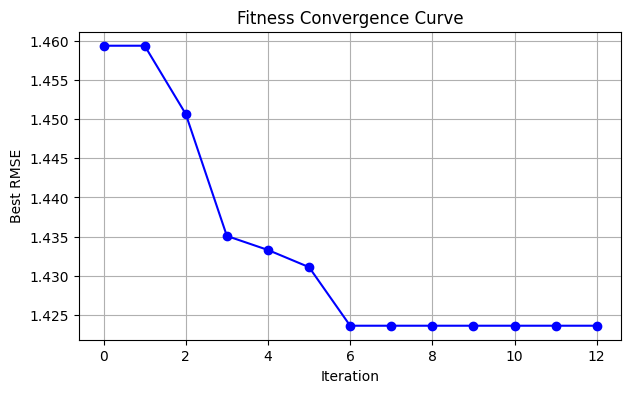

Best Parameters: {'n_estimators': 100, 'learning_rate': 0.17571144963820087}, Best Loss: 1.4236


Optimizing GradientBoosting using PSO...
iteration number0
Iteration 1/12, Best Loss: 2.5033
iteration number1
Iteration 2/12, Best Loss: 2.4394
iteration number2
Iteration 3/12, Best Loss: 2.4394
iteration number3
Iteration 4/12, Best Loss: 2.4394
iteration number4
Iteration 5/12, Best Loss: 2.4394
iteration number5
Iteration 6/12, Best Loss: 2.4394
iteration number6
Iteration 7/12, Best Loss: 2.4284
iteration number7
Iteration 8/12, Best Loss: 2.4025
iteration number8
Iteration 9/12, Best Loss: 2.4025
iteration number9
Iteration 10/12, Best Loss: 2.4025
iteration number10
Iteration 11/12, Best Loss: 2.4024
iteration number11
Iteration 12/12, Best Loss: 2.4024


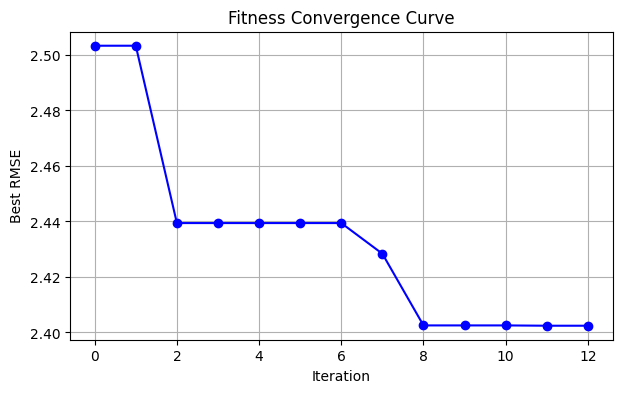

Best Parameters: {'n_estimators': 100, 'learning_rate': 0.1968160138750883}, Best Loss: 2.4024



In [22]:

if __name__ == "__main__":
    # from sklearn.datasets import make_regression
    # X, Y = make_regression(n_samples=500, n_features=10, noise=0.3, random_state=42)
    # X_train, X_test, Y_train, Y_test = train_test_split(X, Y ,test_size=0.2, random_state=42)
    X_train, X_test, Y_train, Y_test = train_test_split(dfx1, dfy1 ,test_size=0.2, random_state=42)
    
    GLOBAL_DATA['X_train'], GLOBAL_DATA['X_test'] = X_train, X_test
    GLOBAL_DATA['y_train'], GLOBAL_DATA['y_test'] = np.array(Y_train).ravel().copy(), np.array(Y_test).ravel().copy()


    models = {
        # "DecisionTree": (DecisionTreeRegressor, {"max_depth": (1, 20), "min_samples_split": (2, 10)}),
        "XGBRegressor": (XGBRegressor, {"n_estimators": (50, 100), "learning_rate": (0.05, 0.2)}),

        "GradientBoosting": (GradientBoostingRegressor, {"n_estimators": (50, 100), "learning_rate": (0.05, 0.2)}),
        # "RandomForest": (RandomForestRegressor, {"n_estimators": (50, 100), "max_depth": (1, 20)}),
        
        
    }

    for name, (model_class, param_bounds) in models.items():
        print(f"\nOptimizing {name} using PSO...")
        best_params, best_loss = regression_pso(model_class, param_bounds, X_train, X_test, Y_train, Y_test)
        print(f"Best Parameters: {best_params}, Best Loss: {best_loss:.4f}\n")


In [26]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from joblib import Parallel, delayed
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
GLOBAL_DATA = {}



# Particle class for PSO
class Particle:
    def __init__(self, dim, bounds):
        self.position = np.array([random.uniform(bounds[d][0], bounds[d][1]) for d in range(dim)])
        self.velocity = np.zeros(dim)
        self.best_position = np.copy(self.position)
        self.best_score = float('inf')

# PSO Optimization
def pso_optimize(func, dim, bounds, n_particles=7, max_iter=20, w=0.5, c1=1.5, c2=1.5, early_stop=5):
    particles = [Particle(dim, bounds) for _ in range(n_particles)]
    global_best = min(particles, key=lambda p: func(p.position))

    best_loss = func(global_best.position)
    no_improve_count = 0
    fitness_history = [best_loss]  # track fitness over iterations

    for it in range(max_iter):
        print(f"iteration number{it}")
        scores = Parallel(n_jobs=-1)(delayed(func)(p.position) for p in particles)

        improved = False
        for i, particle in enumerate(particles):
            score = scores[i]

            # Update personal best
            if score < particle.best_score:
                particle.best_score = score
                particle.best_position = np.copy(particle.position)

            # Update global best
            if score < best_loss:
                global_best = particle
                best_loss = score
                no_improve_count = 0
                improved = True
            else:
                no_improve_count += 1

            # Update velocity and position
            inertia = w * particle.velocity
            cognitive = c1 * random.random() * (particle.best_position - particle.position)
            social = c2 * random.random() * (global_best.position - particle.position)
            particle.velocity = inertia + cognitive + social
            particle.position += particle.velocity
            particle.position = np.clip(particle.position, [b[0] for b in bounds], [b[1] for b in bounds])

        fitness_history.append(best_loss)
        # print(best_loss)

        print(f"Iteration {it+1}/{max_iter}, Best Loss: {best_loss:.4f}")

        # # Early stopping
        # if not improved:
        #     no_improve_count += 1
        # if no_improve_count >= early_stop:
        #     print("Early stopping triggered.")
        #     break

    # Plot fitness curve
    plt.figure(figsize=(7, 4))
    plt.plot(fitness_history, marker='o', linestyle='-', color='blue')
    plt.title("Fitness Convergence Curve")
    plt.xlabel("Iteration")
    plt.ylabel("Best MSE")
    plt.grid(True)
    plt.show()

    return global_best.position, best_loss


# Regression PSO function
def regression_pso(model_class, param_bounds, X_train, X_test, y_train, y_test, n_particles=7, max_iter=12):
    def model_fitness(params):
        X_train, X_test = GLOBAL_DATA['X_train'], GLOBAL_DATA['X_test']
        y_train, y_test = GLOBAL_DATA['y_train'], GLOBAL_DATA['y_test']
        
        params = {key: int(val) if isinstance(param_bounds[key][0], int) else val for key, val in zip(param_bounds.keys(), params)}
        model_args = params.copy()
        if 'n_jobs' not in model_args and 'n_jobs' in model_class().get_params().keys():
            model_args['n_jobs'] = -1

        model = model_class(**model_args)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return mean_squared_error(y_test, y_pred)

    bounds = list(param_bounds.values())
    best_params, best_loss = pso_optimize(model_fitness, len(bounds), bounds, n_particles, max_iter)

    best_params_dict = {key: int(val) if isinstance(param_bounds[key][0], int) else val for key, val in zip(param_bounds.keys(), best_params)}
    return best_params_dict, best_loss


# Example usage


Optimizing XGBRegressor using PSO...
iteration number0
Iteration 1/12, Best Loss: 2.1214
iteration number1
Iteration 2/12, Best Loss: 2.0602
iteration number2
Iteration 3/12, Best Loss: 2.0398
iteration number3
Iteration 4/12, Best Loss: 2.0398
iteration number4
Iteration 5/12, Best Loss: 2.0398
iteration number5
Iteration 6/12, Best Loss: 2.0398
iteration number6
Iteration 7/12, Best Loss: 2.0398
iteration number7
Iteration 8/12, Best Loss: 2.0398
iteration number8
Iteration 9/12, Best Loss: 2.0398
iteration number9
Iteration 10/12, Best Loss: 2.0398
iteration number10
Iteration 11/12, Best Loss: 2.0398
iteration number11
Iteration 12/12, Best Loss: 2.0398


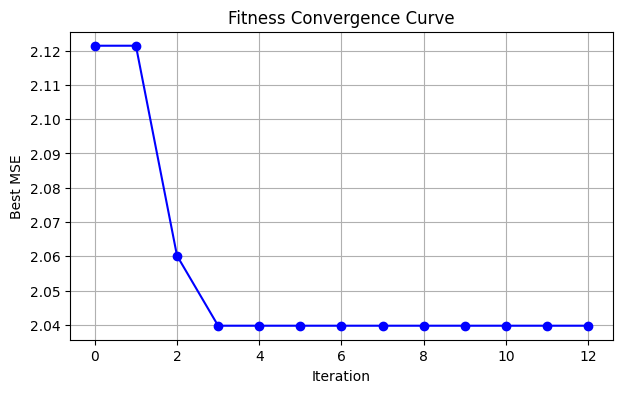

Best Parameters: {'n_estimators': 100, 'learning_rate': 0.1975592973214613}, Best Loss: 2.0398


Optimizing GradientBoosting using PSO...
iteration number0
Iteration 1/12, Best Loss: 6.2482
iteration number1
Iteration 2/12, Best Loss: 6.0996
iteration number2
Iteration 3/12, Best Loss: 5.7845
iteration number3
Iteration 4/12, Best Loss: 5.7845
iteration number4
Iteration 5/12, Best Loss: 5.7845
iteration number5
Iteration 6/12, Best Loss: 5.7534
iteration number6
Iteration 7/12, Best Loss: 5.6035
iteration number7
Iteration 8/12, Best Loss: 5.6035
iteration number8
Iteration 9/12, Best Loss: 5.6035
iteration number9
Iteration 10/12, Best Loss: 5.6035
iteration number10
Iteration 11/12, Best Loss: 5.6035
iteration number11
Iteration 12/12, Best Loss: 5.6035


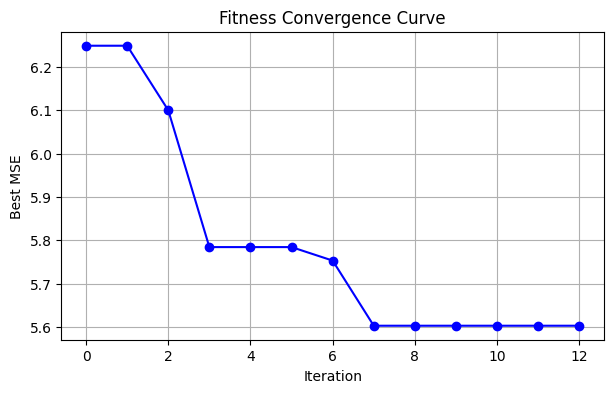

Best Parameters: {'n_estimators': 100, 'learning_rate': 0.1404683564087584}, Best Loss: 5.6035



In [27]:

if __name__ == "__main__":
    # from sklearn.datasets import make_regression
    # X, Y = make_regression(n_samples=500, n_features=10, noise=0.3, random_state=42)
    # X_train, X_test, Y_train, Y_test = train_test_split(X, Y ,test_size=0.2, random_state=42)
    X_train, X_test, Y_train, Y_test = train_test_split(dfx1, dfy1 ,test_size=0.2, random_state=42)
    
    GLOBAL_DATA['X_train'], GLOBAL_DATA['X_test'] = X_train, X_test
    GLOBAL_DATA['y_train'], GLOBAL_DATA['y_test'] = np.array(Y_train).ravel().copy(), np.array(Y_test).ravel().copy()


    models = {
        # "DecisionTree": (DecisionTreeRegressor, {"max_depth": (1, 20), "min_samples_split": (2, 10)}),
        "XGBRegressor": (XGBRegressor, {"n_estimators": (50, 100), "learning_rate": (0.05, 0.2)}),

        "GradientBoosting": (GradientBoostingRegressor, {"n_estimators": (50, 100), "learning_rate": (0.05, 0.2)}),
        # "RandomForest": (RandomForestRegressor, {"n_estimators": (50, 100), "max_depth": (1, 20)}),
        
        
    }

    for name, (model_class, param_bounds) in models.items():
        print(f"\nOptimizing {name} using PSO...")
        best_params, best_loss = regression_pso(model_class, param_bounds, X_train, X_test, Y_train, Y_test)
        print(f"Best Parameters: {best_params}, Best Loss: {best_loss:.4f}\n")
